In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    precision_score,
mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.model_selection import train_test_split

from fairness_measures import *

df = pd.read_csv("all_vals_race1_interestrate1.csv")


df.drop(
    columns=[
        "IsTestData",
        "IsCalibrateData",
        "v1",
        "istestdata2",
        "iscalibratedata2",
    ],
    inplace=True,
)

# df = df[df["zip"].notna() & (df["zip"] != 0)].copy()
# df["zip_avg_rate"] = df.groupby("zip")["cur_int_rate"].transform("mean")
# county_dummies = pd.get_dummies(df["COUNTY"], prefix="COUNTY", drop_first=True)
# df = pd.concat([df, county_dummies], axis=1)


df["minority"] = (
    (df["race_dum_Black"] == 1)
    | (df["race_dum_Native Am, Alaska, Hawaii"] == 1)
    | (df["ethnicity_dum_hisp"] == 1)
    # | (df['race_dum_Asian'] == 1)
)

# df["race_dum_White"] = (df["race_dum_White hisp"] | df["race_dum_White_non_hisp"]).astype(int)
# df = df.drop(columns=["race_dum_White hisp", "race_dum_White_non_hisp"])


valid_race_cols = [
    "race_dum_White hisp",
    "race_dum_Unknown",
    "race_dum_White_non_hisp",
    "race_dum_Asian",
    "race_dum_Black",
    "race_dum_Native Am, Alaska, Hawaii",
    ]

df = df[df[valid_race_cols].sum(axis=1) == 1].copy()

features = df.drop(
    columns=[
        "default", "cur_int_rate", "sato", "minority", 'default_age', 'prepayment', 
        'zip',
        "COUNTY",
        # "log_org_amt",
        # 'orig_amt', 'fico_orig_miss', 'income_miss',
        # 'document_type_dum_1', 'document_type_dum_2', 'document_type_dum_3',
        # # 'loan_purpose_dum_1', 'orig_year_dum_2018',
        # "race_dum_Unknown", "race_dum_Asian", "race_dum_Black",
        # "race_dum_Native Am, Alaska, Hawaii", "race_dum_White hisp", "race_dum_White non-hisp"
    ],
    axis=1
)

target = df["cur_int_rate"] * 100


features_numeric = pd.get_dummies(features, drop_first=True)

sensitive_features = df["minority"]

C:\Users\bencu\AppData\Local\Temp\ipykernel_34184\4137679964.py:18: DtypeWarning: Columns (101) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("all_vals_race1_interestrate1.csv")


In [2]:
for col in valid_race_cols:
    avg_rate = df.loc[df[col] == 1, "cur_int_rate"].mean()
    print(f"{col}: {avg_rate}")

race_dum_White hisp: 0.04638729245381122
race_dum_Unknown: 0.04371068002786562
race_dum_White_non_hisp: 0.043656006035167276
race_dum_Asian: 0.041365119758564696
race_dum_Black: 0.045410706843055836
race_dum_Native Am, Alaska, Hawaii: 0.045992461990545554


In [3]:
features_numeric.rename(
    columns={
        "occupancy_type_dum_1": "occupancy_primary",
        "occupancy_type_dum_2": "occupancy_secondary",
    },
    inplace=True,
)

features_numeric["occupancy_unknown"] = (
    (features_numeric["occupancy_primary"] == 0) & (features_numeric["occupancy_secondary"] == 0)
).astype(int)

In [4]:
features_numeric.rename(
    columns={
        "investor_type_dum_1": "investor_fannie_mae",
        "investor_type_dum_2": "investor_ginnie_mae",
        "investor_type_dum_3": "investor_freddie_mac",
    },
    inplace=True,
)

features_numeric["investor_gse"] = (
    (features_numeric["investor_fannie_mae"] == 1)
    | (features_numeric["investor_ginnie_mae"] == 1)
    | (features_numeric["investor_freddie_mac"] == 1)
).astype(int)

features_numeric["investor_other"] = (
    (features_numeric["investor_fannie_mae"] == 0)
    & (features_numeric["investor_ginnie_mae"] == 0)
    & (features_numeric["investor_freddie_mac"] == 0)
).astype(int)

features_numeric.drop(columns=["investor_fannie_mae",
        "investor_ginnie_mae",
       "investor_freddie_mac",], inplace=True, axis=1)

In [5]:
# Create FICO indicator bins from fico_orig_fill
s = features["fico_orig_fill"]

features["FICO580"] = (s < 580).astype(int)
features["FICO620"] = ((s >= 580) & (s < 620)).astype(int)
features["FICO660"] = ((s >= 620) & (s < 660)).astype(int)
features["FICO700"] = ((s >= 660) & (s < 700)).astype(int)

# Keep features_numeric in sync
s_num = features_numeric["fico_orig_fill"]
features_numeric["FICO580"] = (s_num < 580).astype(int)
features_numeric["FICO620"] = ((s_num >= 580) & (s_num < 620)).astype(int)
features_numeric["FICO660"] = ((s_num >= 620) & (s_num < 660)).astype(int)
features_numeric["FICO700"] = ((s_num >= 660) & (s_num < 700)).astype(int)
features_numeric["FICO700+"] = (s_num >= 700).astype(int)
features_numeric.drop(columns=["fico_orig_fill"], axis=1, inplace=True)

In [6]:
features["applicant_income"] = features["applicant_income"].where(
    (features["applicant_income"] >= 0) & (features["applicant_income"] <= 1000), np.nan
)

bin_edges = list(range(0, 550, 100)) + [np.inf]  # 0-50-100-...-1000-1000+
bin_labels = [f"{i}-{i+100}" for i in range(0, 500, 100)] + ["500+"]

# Create binned feature
features["applicant_income_bin"] = pd.cut(
    features["applicant_income"],
    bins=bin_edges,
    labels=bin_labels,
    right=False,
    include_lowest=True,
)

# One-hot encode
to_drop = [c for c in features_numeric.columns if c.startswith("income_bin_")]
if to_drop:
    features_numeric.drop(columns=to_drop, inplace=True)

income_bin_dummies = pd.get_dummies(
    features["applicant_income_bin"], prefix="income_bin", dtype=int
)
features_numeric = pd.concat([features_numeric, income_bin_dummies], axis=1)
features_numeric.drop(columns=["applicant_income"], axis=1, inplace=True)

In [7]:
features["ltv_ratio_fill"] = features["ltv_ratio_fill"].where(
    (features["ltv_ratio_fill"] >= 0) & (features["ltv_ratio_fill"] <= 2), np.nan
)

# Convert to percentage scale (0–100+)
ltv_pct = features["ltv_ratio_fill"] * 100

# Define bins: first 0–50%, then 50–60%, 60–70%, ..., 90–100%, 100%+
bin_edges = [0, 50, 60, 70, 80, 90, 100, np.inf]
bin_labels = ["0-50%", "50-60%", "60-70%", "70-80%", "80-90%", "90-100%", "100%+"]

# Create binned feature
features["ltv_bin"] = pd.cut(
    ltv_pct, bins=bin_edges, labels=bin_labels, right=False, include_lowest=True
)

# One-hot encode LTV bins
to_drop = [c for c in features_numeric.columns if c.startswith("ltv_bin_")]
if to_drop:
    features_numeric.drop(columns=to_drop, inplace=True)

ltv_bin_dummies = pd.get_dummies(features["ltv_bin"], prefix="ltv_bin", dtype=int)
features_numeric = pd.concat([features_numeric, ltv_bin_dummies], axis=1)
features_numeric.drop(columns=["ltv_ratio_fill"], axis=1, inplace=True)

In [8]:
def evaluate_fairness(y_pred, target, minority):
    fairness_metrics = FairnessMetrics(y_pred, target, minority)
    metrics = fairness_metrics.calculate_metrics_with_cross_validation()
    fairness_metrics.train_classifiers(split_data=False)
    print(metrics)
    print(f"R² Score: {r2_score(target, y_pred):.4f}")
    for criterion in ["independence", "separation", "sufficiency"]:
        fairness_metrics.plot_roc_auc_curve(criterion)
    
    return metrics

In [9]:
print(features_numeric.columns)

# features_numeric.drop(labels=["race_dum_White_non_hisp"], axis=1, inplace=True)
# features_numeric.drop(labels=["loan_Conventional"], axis=1, inplace=True)
# features_numeric.drop(labels=["ltv_bin_0-50%"], axis=1, inplace=True)
# features_numeric.drop(labels=["income_bin_0-100"], axis=1, inplace=True)
# features_numeric.drop(labels=["FICO580"], axis=1, inplace=True)
# features_numeric.drop(labels=["occupancy_primary"], axis=1, inplace=True)
# features_numeric.drop(labels=["orig_year_dum_2018"], axis=1, inplace=True)
# features_numeric.drop(labels=["investor_other"], axis=1, inplace=True)
# features_numeric.drop(labels=["orig_amt"], axis=1, inplace=True)

# features_numeric.drop(
#     labels=[c for c in df.columns if c.startswith("document_type_dum_")], axis=1, inplace=True
# )
# features_numeric.drop(
#     labels=[c for c in df.columns if c.startswith("loan_purpose_dum_")], axis=1, inplace=True
# )

Index(['income_miss', 'fico_orig_miss', 'orig_amt', 'log_org_amt',
       'loan_Conventional', 'loan_FHA', 'loan_VA', 'occupancy_primary',
       'occupancy_secondary', 'jumbo_flg_dum_n',
       ...
       'income_bin_300-400', 'income_bin_400-500', 'income_bin_500+',
       'ltv_bin_0-50%', 'ltv_bin_50-60%', 'ltv_bin_60-70%', 'ltv_bin_70-80%',
       'ltv_bin_80-90%', 'ltv_bin_90-100%', 'ltv_bin_100%+'],
      dtype='object', length=105)


In [10]:
race_cols = [
    "race_dum_Asian",
    "race_dum_Black",
    "race_dum_Native Am, Alaska, Hawaii",
    "race_dum_White hisp",
    "race_dum_Unknown",
]

# Loan type dummy
loan_col = "loan_type_mcdash_dum_c"

# FICO dummies
fico_cols = ["FICO620", "FICO660", "FICO700", "FICO700+"]

# Create race × FICO interactions
# for race in race_cols:
#     for fico in fico_cols:
#         interaction_name = f"{race}_x_{fico}"
#         features_numeric[interaction_name] = features_numeric[race] * features_numeric[fico]

# print("Interaction terms created successfully.")

In [11]:
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val, sensitive_train, sensitive_val = train_test_split(
    features_numeric, target, sensitive_features, test_size=0.1, random_state=42
)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features_numeric.columns, index=X_train.index)

In [12]:
X_val_scaled = scaler.transform(X_val)

ols_model = sm.OLS(y_train, sm.add_constant(X_train))
result = ols_model.fit(cov_type="HC3")

y_pred = result.predict(sm.add_constant(X_train))

y_val_pred = result.predict(sm.add_constant(X_val_scaled))
print(f"OLS R² Score: {r2_score(y_val, y_val_pred):.4f}")
print(f"OLS RMSE: {np.sqrt(mean_squared_error(y_val, y_val_pred)):.4f}")

OLS R² Score: 0.7241
OLS RMSE: 0.7610


In [13]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           cur_int_rate   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                 7.717e+15
Date:                Fri, 07 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:21:11   Log-Likelihood:            -1.3240e+06
No. Observations:             1154086   AIC:                         2.648e+06
Df Residuals:                 1153988   BIC:                         2.649e+06
Df Model:                          97                                         
Covariance Type:                  HC3                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 105, but rank is 6
  warnings.warn('covariance of constraints does not have full '


In [14]:
for col in [c for c in features_numeric.columns if c.startswith("loan_type_mcdash_dum_c")]:
    print(col, features_numeric[col].value_counts())

loan_type_mcdash_dum_c loan_type_mcdash_dum_c
1    1179624
0     102694
Name: count, dtype: int64


In [15]:
lr_full = LinearRegression()
lr_full.fit(X_train, y_train)

y_pred_lr = lr_full.predict(X_train)

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
)
# rf.fit(features_numeric, target)

y_pred_rf = rf.predict(features_numeric)

evaluate_fairness(y_pred_rf, target, df["minority"])

print(f"Random Forest R² Score: {r2_score(target, y_pred_rf):.4f}")

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
from sklearn.linear_model import LassoCV
import numpy as np

lasso_cv = LassoCV(alphas=np.logspace(-4, 0, 50), cv=5)
lasso_cv.fit(features_numeric, target)

print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.00021209508879201905


In [20]:
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)


# Fit the model
lasso = Lasso(alpha=0.001)
lasso.fit(features_numeric, target)

# Predictions
y_pred_lasso = lasso.predict(features_numeric)

# Summary
summary = pd.DataFrame({"Feature": features_numeric.columns, "Coefficient": lasso.coef_})
summary["Abs(Coefficient)"] = np.abs(summary["Coefficient"])
summary = summary.sort_values(by="Abs(Coefficient)", ascending=False)

print("Intercept:", lasso.intercept_)
print("\nLasso Regression Summary:")
print(summary)

Intercept: 7.776456747306593

Lasso Regression Summary:
                                Feature   Coefficient  Abs(Coefficient)
22                   orig_year_dum_2023  1.983181e+00      1.983181e+00
23                   orig_year_dum_2024  1.920826e+00      1.920826e+00
20                   orig_year_dum_2021 -1.525574e+00      1.525574e+00
19                   orig_year_dum_2020 -1.302748e+00      1.302748e+00
18                   orig_year_dum_2019 -5.074068e-01      5.074068e-01
14                    term_nmon_dum_180 -5.037547e-01      5.037547e-01
13                    term_nmon_dum_120 -4.232864e-01      4.232864e-01
91                             FICO700+ -3.968528e-01      3.968528e-01
16               loan_type_mcdash_dum_c  3.241015e-01      3.241015e-01
0                           income_miss  3.154756e-01      3.154756e-01
21                   orig_year_dum_2022  2.743525e-01      2.743525e-01
3                           log_org_amt -2.518587e-01      2.518587e-01
88      

c:\Users\bencu\anaconda3\envs\aif360\Lib\site-packages\sklearn\linear_model\_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.49359e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


{'mean_metrics': {'independence': 0.006102554423145147, 'separation': 0.001681536430246861, 'sufficiency': 2.4807758476481237e-07}, 'std_metrics': {'independence': 5.08234410294371e-05, 'separation': 3.4384299041775224e-05, 'sufficiency': 3.060179414036087e-07}}
R² Score: 0.7219


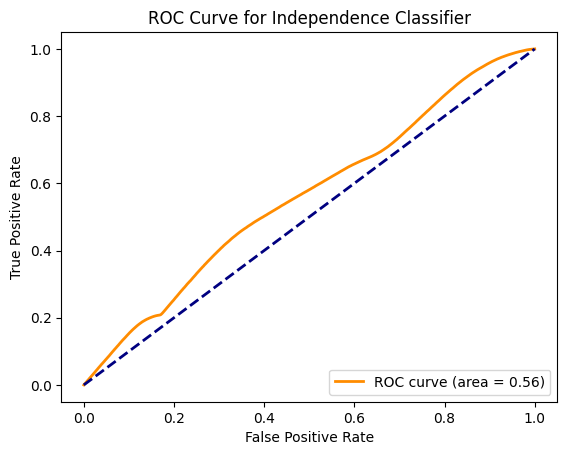

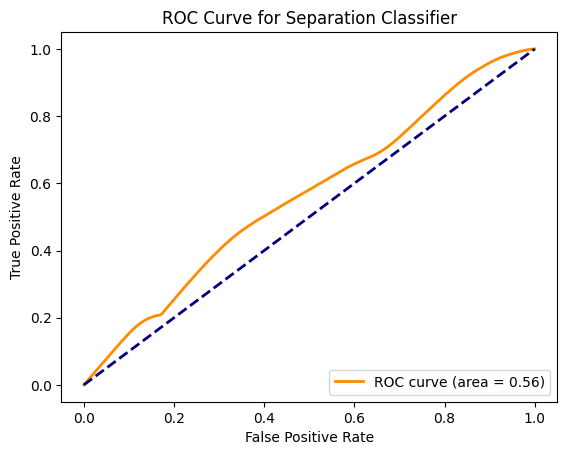

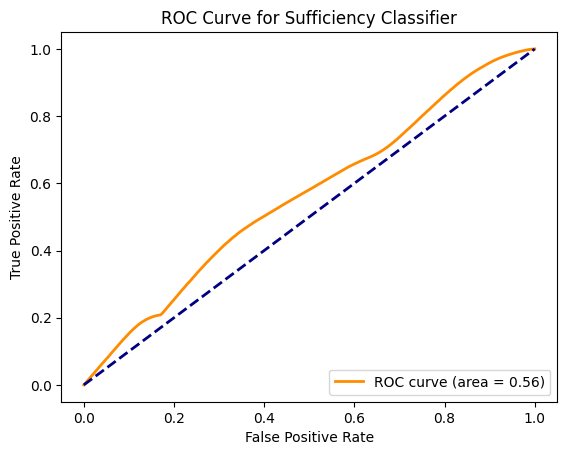

{'mean_metrics': {'independence': 0.006102554423145147,
  'separation': 0.001681536430246861,
  'sufficiency': 2.4807758476481237e-07},
 'std_metrics': {'independence': 5.08234410294371e-05,
  'separation': 3.4384299041775224e-05,
  'sufficiency': 3.060179414036087e-07}}

In [ ]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.1)
ridge.fit(features_numeric, target)

y_pred_ridge = ridge.predict(features_numeric)

evaluate_fairness(y_pred_ridge, target, df["minority"])

{'mean_metrics': {'independence': 0.003680764157043141, 'separation': 0.00014993299652780095, 'sufficiency': 0.000900530660475589}, 'std_metrics': {'independence': 4.4163528071673565e-05, 'separation': 1.0181486155087429e-05, 'sufficiency': 1.9581547629478573e-05}}
R² Score: 0.6171


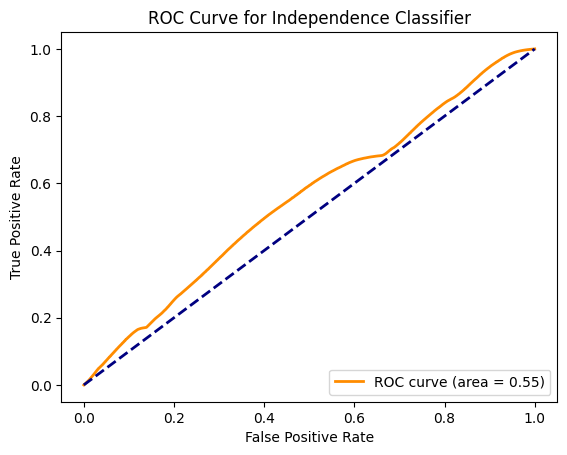

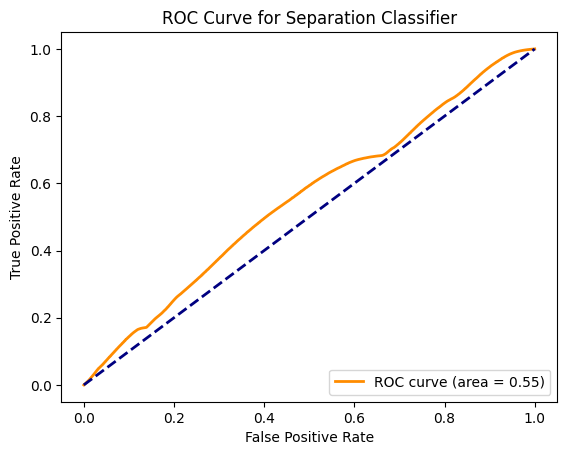

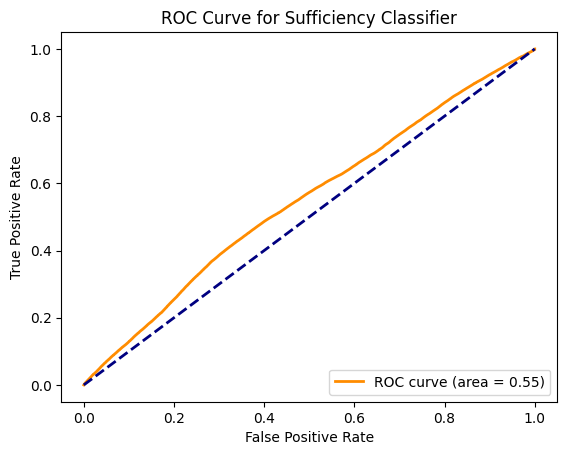

In [ ]:
from sklearn.linear_model import ElasticNet

elastic = ElasticNet(alpha=0.001)
elastic.fit(features_numeric, target)

y_pred_elastic = elastic.predict(features_numeric)




auc_elastic = evaluate_fairness(y_pred_elastic, target, df["minority"])